First, necessary imports and control methods definitions:

In [2]:
from vrep import vrep
import sys
import time
import numpy as np

import skfuzzy
import matplotlib.pyplot as plt

In [3]:
def get_handle_by_name(name):
    err_code, handle = vrep.simxGetObjectHandle(clientID, name, vrep.simx_opmode_blocking)
    if err_code != 0:
        print('Error getting handle:', err_code)
    return handle


def get_handle_position(handle, relative_to_object_handle=-1, mode=vrep.simx_opmode_buffer):
    err_code, position = vrep.simxGetObjectPosition(clientID, handle, relative_to_object_handle, vrep.simx_opmode_streaming)
    if err_code != 0:
        print('Error getting position:', err_code)
    return position


def set_crane_velocity(velocity):
    err_code1 = vrep.simxSetJointTargetVelocity(clientID, lb_motor_handle, velocity, vrep.simx_opmode_streaming)
    err_code2 = vrep.simxSetJointTargetVelocity(clientID, rb_motor_handle, velocity, vrep.simx_opmode_streaming)
    err_code3 = vrep.simxSetJointTargetVelocity(clientID, lf_motor_handle, velocity, vrep.simx_opmode_streaming)
    err_code4 = vrep.simxSetJointTargetVelocity(clientID, rf_motor_handle, velocity, vrep.simx_opmode_streaming)
    if err_code1 != 0:
        print('Error setting velocity for lb_handle:', err_code1)
    if err_code2 != 0:
        print('Error setting velocity for rb_handle:', err_code2)
    if err_code3 != 0:
        print('Error setting velocity for lf_handle:', err_code3)
    if err_code4 != 0:
        print('Error setting velocity for rf_handle:', err_code4)


def stop_crane():
    set_crane_velocity(0)


def distance_from_position_x_axis(x_position):
    return abs(x_position - get_crane_center()[0])

Connect to the simulation and get the handles

In [4]:
vrep.simxFinish(-1) # closes all opened connections, in case any prevoius wasnt finished
clientID= vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5) # start a connection

if clientID!=-1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

# get handles to robot drivers
lf_motor_handle = get_handle_by_name("WheelJoint_LF")
lb_motor_handle = get_handle_by_name("WheelJoint_LB")
rb_motor_handle = get_handle_by_name("WheelJoint_RB")
rf_motor_handle = get_handle_by_name("WheelJoint_RF")

lf_wheel_base_handle = get_handle_by_name("WheelBase_respondable")
lb_wheel_base_handle = get_handle_by_name("WheelBase_respondable0")
rb_wheel_base_handle = get_handle_by_name("WheelBase_respondable1")
rf_wheel_base_handle = get_handle_by_name("WheelBase_respondable2")
load_handle = get_handle_by_name("Load")

def get_crane_center():
    lf_position = get_handle_position(lf_wheel_base_handle)
    lb_position = get_handle_position(lb_wheel_base_handle)
    rb_position = get_handle_position(rb_wheel_base_handle)
    rf_position = get_handle_position(rf_wheel_base_handle)
    return np.mean([lf_position, lb_position, rb_position, rf_position], axis=0)

Connected to remote API server


Let's estimate the range of the crane movement

In [7]:
# set_crane_velocity(5)
# time.sleep(10)
MIN_CRANE_X = -1.5
# set_crane_velocity(-5)
# time.sleep(10)
MAX_CRANE_X = 1.5
print('Min x:', MIN_CRANE_X)
print('Max x:', MAX_CRANE_X)

Min x: -1.5
Max x: 1.5


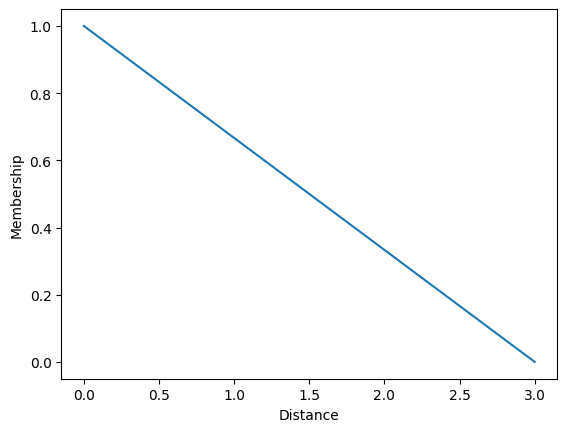

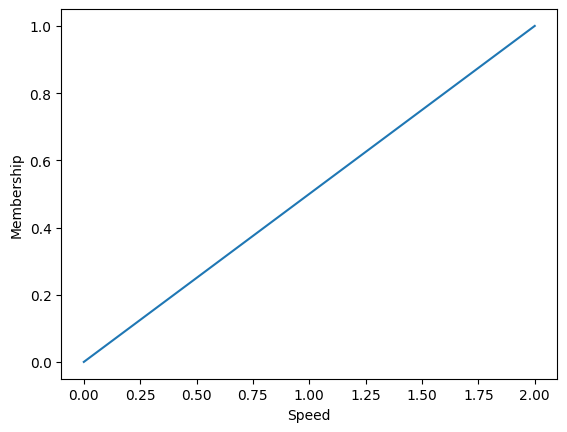

In [8]:
MAX_CRANE_X_PERCENT = MAX_CRANE_X*2/100

distance_universe = np.linspace(0, MAX_CRANE_X*2, 1000)
distance_fuzz = skfuzzy.trimf(distance_universe, [0, 0, MAX_CRANE_X*2])
plt.plot(distance_universe, distance_fuzz)
plt.xlabel('Distance')
plt.ylabel('Membership')
plt.show()

speed_universe = np.linspace(0, 2, 1000)
speed_fuzz = skfuzzy.trimf(speed_universe, [0, 2, 2])
plt.plot(speed_universe, speed_fuzz)
plt.xlabel('Speed')
plt.ylabel('Membership')
plt.show()

Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error setting velocity for lb_handle: 1
Error setting velocity for rb_handle: 1
Error setting velocity for lf_handle: 1
Error setting velocity for rf_handle: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error setting velocity for lb_handle: 1
Error setting velocity for rb_handle: 1
Error setting velocity for lf_handle: 1
Error setting velocity for rf_handle: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error getting position: 1
Error setting velocity for lb_handle: 1
Error setting ve

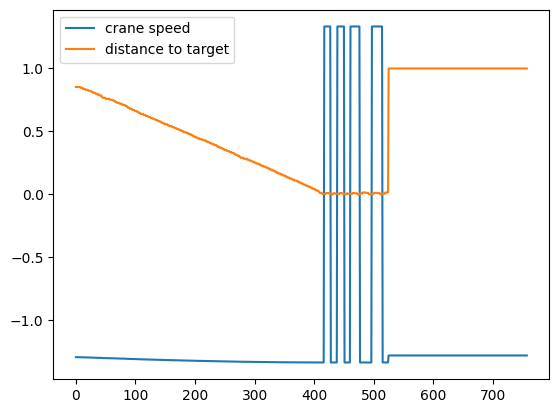

In [10]:
def simulate_crane_movement(target_position, sim_time):
    # Clamp target position to the crane movement range
    target_position = np.clip(target_position, MIN_CRANE_X, MAX_CRANE_X)
    
    # Init speed and distance history for plotting
    speed_history = []
    distance_history = []
    
    start_time = time.time()
    while time.time() - start_time < sim_time:
        crane_position_x = get_crane_center()[0]
        distance_to_target = distance_from_position_x_axis(target_position)

        distance_mf = skfuzzy.interp_membership(distance_universe, distance_fuzz, distance_to_target)
        speed = skfuzzy.defuzz(speed_universe, np.fmin(speed_fuzz, distance_mf), 'centroid')
        if crane_position_x < target_position:
            speed = -speed
        set_crane_velocity(speed)

        distance_history.append(distance_to_target)
        speed_history.append(speed)

        time.sleep(0.01)

    stop_crane()
    plt.plot(np.arange(len(speed_history)), speed_history, label='crane speed')
    plt.plot(np.arange(len(distance_history)), distance_history, label='distance to target')
    plt.legend()

simulate_crane_movement(1, 15)